<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [23]:
%matplotlib inline

import os
import json
import gzip
import copy
import catboost
import sys
import string
import ast
import colorama
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import norm, skew
from scipy import stats

# Introduce yourself

Put your team name and team-members' names below

Aleksandr Chichkanov

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

# Additional helpful functions

In [ ]:
def load_data(base_dir):
    X = pd.read_csv(base_dir + 'train.tsv/train.tsv', sep='\t')
    X_submit = pd.read_csv(base_dir + 'test_nolabel.tsv/test_nolabel.tsv', sep='\t')
    y = X.pop('sold_fast')
    product_id = X_submit['product_id'].copy()
    return X, y, X_submit, product_id

def save_ans(y, product_id):
    res = pd.concat(
        (
            pd.DataFrame(product_id, columns=['product_id']), 
            pd.DataFrame(y, columns=['score'])
        ),
        axis=1
    )
    res.to_csv('res.csv', index=False)

In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [7]:
def extract_json(x, field_name):
    data = ast.literal_eval(x)
    if isinstance(data, list):
        if data:
            return str(data[0][field_name])
    else:
        return str(data[field_name])
    return 'None'

In [8]:
def norm_text(text, trans):
    return ' '.join(filter(lambda x: len(x) > 3 and not x.isnumeric(), (x for x in text.lower().translate(trans).split())))
    
def norm_texts(texts):
    trans = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    return texts.apply(norm_text, trans=trans)

In [11]:
def pairplot(df, target, show_features=None):
    if show_features is not None:
        df = df[show_features]
    ncol, nrow = 4, df.shape[1] // 4 + (df.shape[1] % 4 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        plt.subplot(nrow, ncol, i + 1)
        plt.scatter(df[feature], target, s=10, marker='o', alpha=.6)
        plt.xlabel(feature)
        if i % ncol == 0:
            plt.ylabel('target')

In [28]:
def distplot(df, show_features=None):
    if show_features is not None:
        df = df[show_features]
    ncol, nrow = 4, df.shape[1] // 4 + (df.shape[1] % 4 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        if df[feature].dtype not in (np.float32, np.float64, np.int32, np.int64):
            continue
        plt.subplot(nrow, ncol, i + 1)
        sns.distplot(df[feature], fit=norm)
        plt.xlabel(feature)

# Data Loading

In [16]:
X, y, X_submit, product_id = load_data('./data/')

In [31]:
X_orig = X

# Preprocess features

In [17]:
binary_features = ['delivery_available', 'payment_available']
cat_features = ['category_id', 'city', 'region', 'sold_mode', 'subcategory_id', 'owner_id'] 
num_features = ['img_num', 'price']
coord_features = ['lat', 'long']
drop_features = ['Unnamed: 0', 'desc_text', 'name_text', 'properties', 'product_id', 'product_type']

In [18]:
X_all = pd.concat([X.copy(), X_submit.copy()])

for f in ('slug_id', 'value_id'):
    X_all[f] = X_all['properties'].apply(extract_json, field_name=f)
    cat_features += [f]

for f in drop_features:
    X_all.drop(f, axis=1, inplace=True)
        
X_all['date_mon'] = pd.to_datetime(X_all['date_created']).dt.month
X_all['date_weekday'] = pd.to_datetime(X_all['date_created']).dt.weekday
X_all.drop('date_created', axis=1, inplace=True)
cat_features += ['date_mon', 'date_weekday']

for col in coord_features:
    X_all[col] = pd.cut(X_all[col], 200).astype(str)

end_cat_features = binary_features + cat_features + coord_features

for f in end_cat_features:
    X_all[f] = LabelEncoder().fit_transform(X_all[f])

X = X_all[:X.shape[0]].copy()
X_submit = X_all[X.shape[0]:].copy()
print(X.shape, X_submit.shape)

((351281, 16), (89251, 16))


Здесь мы достаем признаки из словаря "properties"; разбиваем дату создания на два признака: месяц и день недели; конвертируем координаты в категориальные признаки. В конце все категориальные признаки кодируем числами.

# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

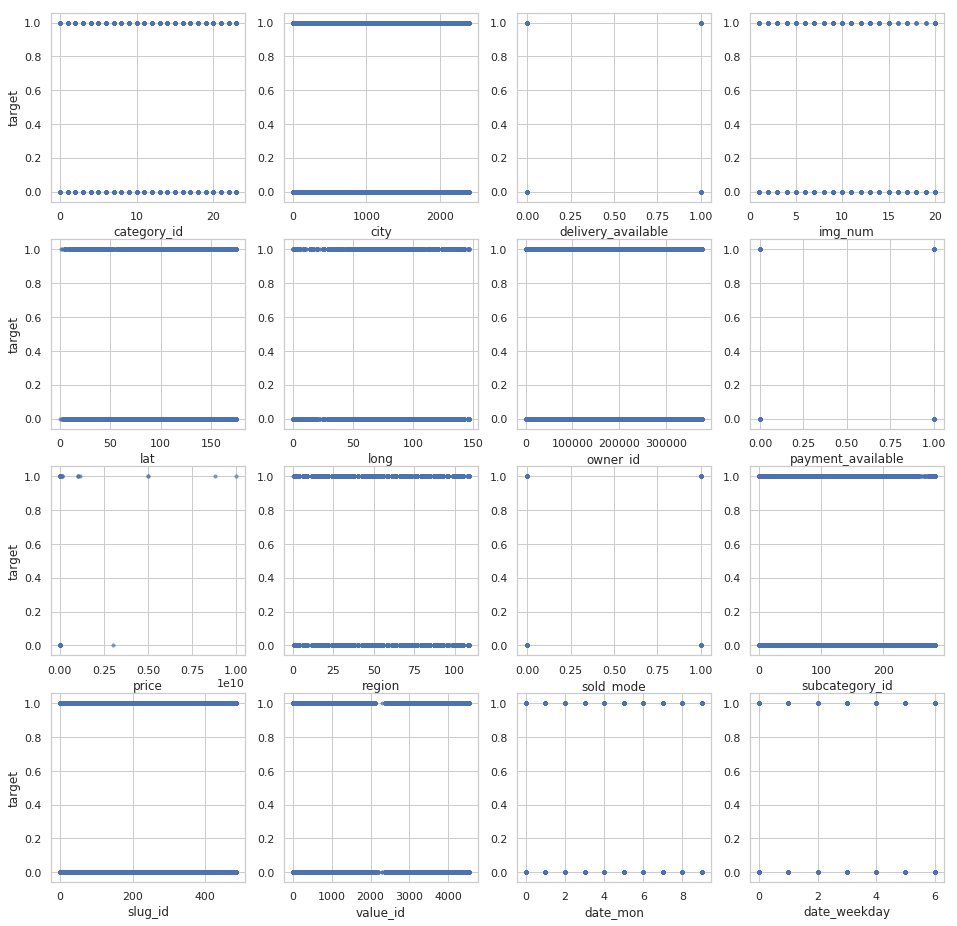

In [19]:
pairplot(X, y)

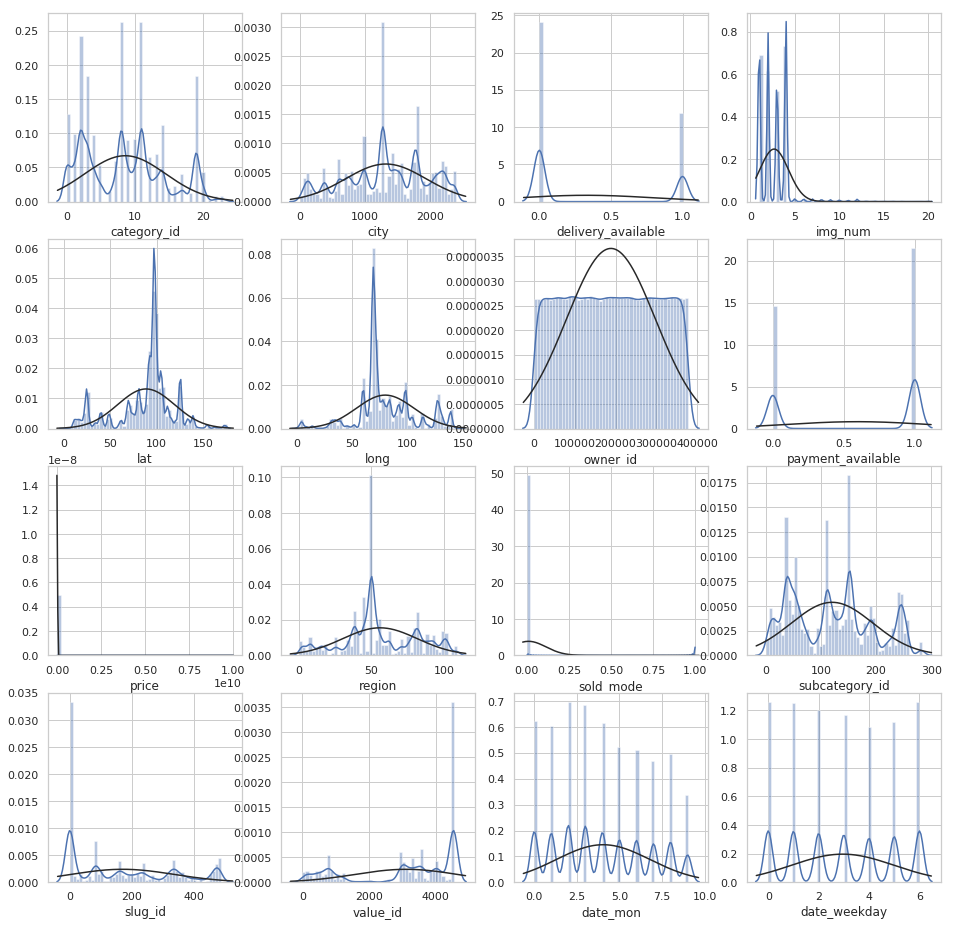

In [29]:
distplot(X)

Заметны выбросы по признаку "цена".

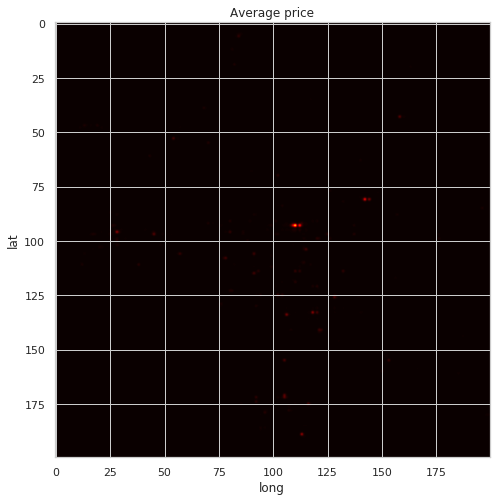

In [33]:
hist, __x, __y = np.histogram2d(
    X_orig['long'],
    X_orig['lat'],
    bins = 200,
    normed = True,
    weights = y,
)

plt.figure(figsize=(8, 8))
plt.xlabel('long')
plt.ylabel('lat')
plt.title('Average price')

plt.imshow(hist, cmap='hot', interpolation='gaussian');

Есть некоторая корреляция с расположением в координатном пространстве.

# (almost) Zero-knowledge prediction
* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

In [36]:
save_ans(np.random.rand(X_submit.shape[0]), product_id)

В качестве ответа будем случайно выбирать $0$ или $1$. На Kaggle это набирает $0.50008$ ROC-AUC.

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

Для начала попробуем просто обучить градиентный бустинг (будем использовать catboost).

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True, random_state=228)
end_cat_features_idx = [X.columns.get_loc(f) for f in end_cat_features]

In [62]:
train_pool_cb = catboost.Pool(X_train, label=y_train, cat_features=end_cat_features_idx)
test_pool_cb = catboost.Pool(X_test, label=y_test, cat_features=end_cat_features_idx)
submit_pool_cb = catboost.Pool(X_submit, cat_features=end_cat_features_idx)

In [63]:
params_cb2 = {
    'loss_function':'Logloss',
    'eval_metric': 'AUC',
    'use_best_model': True,
    #'task_type': 'GPU',
    'one_hot_max_size': 10,
    'metric_period': 100,
    'iterations': 2000,
    'l2_leaf_reg': 1.5,
    'depth': 7,
    'early_stopping_rounds': 200,
    'learning_rate': 0.05
}
model_cb2 = catboost.CatBoost(params_cb2).fit(train_pool_cb, eval_set=test_pool_cb)

0:	test: 0.6146194	best: 0.6146194 (0)	total: 332ms	remaining: 11m 4s
100:	test: 0.6318166	best: 0.6318166 (100)	total: 27.4s	remaining: 8m 35s
200:	test: 0.6352919	best: 0.6352919 (200)	total: 57.1s	remaining: 8m 31s
300:	test: 0.6367867	best: 0.6367867 (300)	total: 1m 26s	remaining: 8m 8s
400:	test: 0.6376913	best: 0.6378333 (388)	total: 1m 56s	remaining: 7m 43s
500:	test: 0.6382539	best: 0.6382979 (496)	total: 2m 25s	remaining: 7m 15s
600:	test: 0.6387449	best: 0.6388004 (584)	total: 2m 56s	remaining: 6m 50s
700:	test: 0.6389070	best: 0.6389595 (693)	total: 3m 26s	remaining: 6m 21s
800:	test: 0.6393401	best: 0.6393634 (798)	total: 3m 56s	remaining: 5m 53s
900:	test: 0.6396166	best: 0.6396743 (857)	total: 4m 26s	remaining: 5m 25s
1000:	test: 0.6401592	best: 0.6401675 (999)	total: 4m 57s	remaining: 4m 56s
1100:	test: 0.6403894	best: 0.6403894 (1100)	total: 5m 27s	remaining: 4m 27s
1200:	test: 0.6404393	best: 0.6405437 (1139)	total: 5m 57s	remaining: 3m 58s
1300:	test: 0.6406338	best: 

Попробуем lgbm.

In [64]:
train_pool_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=end_cat_features_idx)
test_pool_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=end_cat_features_idx)
submit_pool_lgb = lgb.Dataset(X_submit, categorical_feature=end_cat_features_idx)

In [65]:
params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_threads': 2,
    'silent': True,
    'num_iterations': 2000,
    'early_stopping_rounds': 300,
    'lambda_l2': 1.5,
    'learning_rate': 0.05,
    'max_depth': 5, 
    'num_leaves': 20
}
model_lgb = lgb.train(params_lgb, train_pool_lgb, valid_sets=[test_pool_lgb], verbose_eval=400)

Training until validation scores don't improve for 300 rounds.
[400]	valid_0's auc: 0.622674
Early stopping, best iteration is:
[148]	valid_0's auc: 0.624972


Теперь подберем оптимальные параметры, для этого будем использовать hyperopt.

In [ ]:
def opt_params(X, y, base_params, opt_space, mode='cb'):
    if mode == 'cb':
        DataSet = catboost.Pool
    elif  mode == 'lgbm':
        DataSet = lgb.Dataset
    
    obj_call_count = 0
    best_loss = np.inf
    best_params = None
    log_file = sys.stdout # open(mode + '_opt.log', 'w')

    def objective(space):
        nonlocal obj_call_count, best_loss, best_params

        obj_call_count += 1
        print('\nObjective call #{} best_loss={:7.5f}'.format(obj_call_count, best_loss), file=log_file)
        print('Params: {}'.format(json.dumps(space, sort_keys=True)), file=log_file)

        params = copy.deepcopy(base_params)
        params.update(space)

        scores = []
        for train_ind, test_ind in KFold(shuffle=True, random_state=228).split(X, y):
            train_pool = DataSet(X.iloc[train_ind], label=y.iloc[train_ind])
            test_pool = DataSet(X.iloc[test_ind], label=y.iloc[test_ind])

            if mode == 'cb':
                model = catboost.CatBoost(params).fit(train_pool, eval_set=test_pool)
            elif mode == 'lgbm':
                model = lgb.train(params, train_pool, valid_sets=[test_pool], verbose_eval=False)

            pred = model.predict(X.iloc[test_ind]).reshape((-1))
            scores.append(roc_auc_score(y.iloc[test_ind], sigmoid(pred)))

        loss = -np.mean(scores)

        if loss < best_loss:
            best_loss = loss
            best_params = params
            print(colorama.Fore.GREEN + 'NEW BEST LOSS={}, params: {}'.format(best_loss, json.dumps(space, sort_keys=True)) + colorama.Fore.RESET, file=log_file)

        return {'loss': loss, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective,
        space=opt_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        verbose=1
    )
    return best_loss, best_params, best, trials

In [51]:
base_params_cb = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'use_best_model': True,
    'task_type': 'GPU',
    'max_bin': 254,
    'one_hot_max_size': 10,
    #'metric_period': 400,
    'iterations': 1000,
    'early_stopping_rounds': 300,
    'logging_level': 'Silent',
}
space_cb = {
    'depth': hp.choice('depth', [6, 7, 8, 9]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 2, 10)
}

#cb_opt = opt_params(X_train, y_train, base_params_cb, space_cb, mode='cb')
#print(cb_opt)
#print(cb_opt, file=open('cb_params', 'w'))

base_params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_threads': 2,
    'silent': True,
    'num_iterations': 1000,
    'early_stopping_rounds': 300,
    'silent': True,
}
space_lgb = {
    'num_leaves': hp.choice('num_leaves', list(range(40, 55))),
    'max_depth': hp.choice('max_depth', [5, 6, 7, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.4),
    'lambda_l2': hp.uniform('lambda_l2', 1, 6)
}

#lgb_opt = opt_params(X_train, y_train, base_params_lgb, space_lgb, mode='lgbm')
#print(lgb_opt)
#print(lgb_opt, file=open('lgb_params', 'w'))

Примечание: подбор параметров запускался в Kaggle kernel, потому что там есть GPU.

В итоге получаем такие параметры:

In [ ]:
params_cb = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'use_best_model': True,
    'task_type': 'GPU',
    'max_bin': 254,
    'one_hot_max_size': 10,
    'metric_period': 400, 
    'iterations': 2000,
    'early_stopping_rounds': 300,
    'depth': 6,
    'l2_leaf_reg': 9.682707611373381,
    'learning_rate': 0.05038781635607424
}

params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_threads': 2,
    'silent': True,
    'num_iterations': 2000,
    'early_stopping_rounds': 300,
    'lambda_l2': 3.413433548672334,
    'learning_rate': 0.03535376940872917,
    'max_depth': 5, 
    'num_leaves': 40
}

В конце линейно скомбинируем две модели catboost и одну lgbm.

In [68]:
train_pool_cb = catboost.Pool(X_train, label=y_train, cat_features=end_cat_features_idx)
test_pool_cb = catboost.Pool(X_test, label=y_test, cat_features=end_cat_features_idx)
submit_pool_cb = catboost.Pool(X_submit, cat_features=end_cat_features_idx)

train_pool_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=end_cat_features_idx)
test_pool_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=end_cat_features_idx)
submit_pool_lgb = lgb.Dataset(X_submit, categorical_feature=end_cat_features_idx)

params_cb = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'use_best_model': True,
    #'task_type': 'GPU',
    'max_bin': 254,
    'one_hot_max_size': 10,
    'metric_period': 400, 
    'iterations': 2000,
    'early_stopping_rounds': 300,
    'depth': 6,
    'l2_leaf_reg': 9.682707611373381,
    'learning_rate': 0.05038781635607424
}

params_cb2 = {
    'loss_function':'Logloss',
    'eval_metric': 'AUC',
    'use_best_model': True,
    #'task_type': 'GPU',
    'one_hot_max_size': 10,
    'metric_period': 100,
    'iterations': 2000,
    'l2_leaf_reg': 1.5,
    'depth': 7,
    'early_stopping_rounds': 200,
    'learning_rate': 0.05
}

params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_threads': 2,
    'silent': True,
    'num_iterations': 2000,
    'early_stopping_rounds': 300,
    'lambda_l2': 3.413433548672334,
    'learning_rate': 0.03535376940872917,
    'max_depth': 5, 
    'num_leaves': 40
}

model_cb = catboost.CatBoost(params_cb).fit(train_pool_cb, eval_set=test_pool_cb)
model_cb2 = catboost.CatBoost(params_cb2).fit(train_pool_cb, eval_set=test_pool_cb)
model_lgb = lgb.train(params_lgb, train_pool_lgb, valid_sets=[test_pool_lgb], verbose_eval=400)

0:	test: 0.6148388	best: 0.6148388 (0)	total: 324ms	remaining: 10m 46s
400:	test: 0.6376306	best: 0.6376306 (400)	total: 1m 57s	remaining: 7m 47s
800:	test: 0.6396930	best: 0.6397424 (759)	total: 4m	remaining: 5m 59s
1200:	test: 0.6403863	best: 0.6404476 (1143)	total: 6m 1s	remaining: 4m
1600:	test: 0.6407222	best: 0.6408721 (1486)	total: 7m 47s	remaining: 1m 56s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.6408720946
bestIteration = 1486

Shrink model to first 1487 iterations.


0:	test: 0.6165404	best: 0.6165404 (0)	total: 306ms	remaining: 10m 11s
100:	test: 0.6318174	best: 0.6318174 (100)	total: 28.4s	remaining: 8m 53s
200:	test: 0.6365651	best: 0.6365651 (200)	total: 59.3s	remaining: 8m 50s
300:	test: 0.6375942	best: 0.6376387 (298)	total: 1m 30s	remaining: 8m 29s
400:	test: 0.6388441	best: 0.6388441 (400)	total: 2m	remaining: 8m
500:	test: 0.6388727	best: 0.6389399 (489)	total: 2m 31s	remaining: 7m 33s
600:	test: 0.6391798	best: 0.6392144 (597)	total: 3m 2s	remaining: 7m 3s
700:	test: 0.6395285	best: 0.6395702 (698)	total: 3m 33s	remaining: 6m 34s
800:	test: 0.6395099	best: 0.6395702 (698)	total: 4m 2s	remaining: 6m 3s
900:	test: 0.6398170	best: 0.6398170 (900)	total: 4m 33s	remaining: 5m 33s
1000:	test: 0.6400573	best: 0.6400784 (994)	total: 5m 3s	remaining: 5m 3s
1100:	test: 0.6401547	best: 0.6402111 (1042)	total: 5m 34s	remaining: 4m 33s
1200:	test: 0.6404150	best: 0.6404519 (1198)	total: 6m 5s	remaining: 4m 3s
1300:	test: 0.6407953	best: 0.6408698 (127

In [69]:
def predict_y(X, y=None, name=''):
    pred_cb = sigmoid(model_cb.predict(X).reshape((-1)))
    pred_cb2 = sigmoid(model_cb2.predict(X).reshape((-1)))
    pred_lgb = sigmoid(model_lgb.predict(X).reshape((-1)))
    pred = (pred_cb + pred_cb2 + pred_lgb) / 3.0
    
    if y is not None:
        with open(name + '_pred.log', 'w') as f:
            print >> f, 'Scores for', name
            for p in (pred_cb, pred_cb2, pred_lgb, pred):
                print >> f, roc_auc_score(y, p)
            print >> f, ''
    return pred

predict_y(X_train, y_train, 'train')
predict_y(X_test, y_test, 'test')

save_ans(predict_y(X_submit), product_id)

In [70]:
!cat test_pred.log

Scores for test
0.6408720945690765
0.6408726454278064
0.6254206265452505
0.6409562290591054



Этот подход получает скор $0.62453$ на Kaggle.

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?

In [71]:
model_cb.get_feature_importance(prettified=True)

[('price', 21.79030886912423),
 ('subcategory_id', 16.966919102735925),
 ('date_mon', 14.273492830366422),
 ('category_id', 8.237634830500323),
 ('value_id', 5.902084586683116),
 ('owner_id', 4.792605283321397),
 ('city', 4.06666523819776),
 ('lat', 3.998058807651804),
 ('slug_id', 3.726022334453343),
 ('long', 3.50770199659338),
 ('date_weekday', 3.4597591170387703),
 ('region', 2.861769618095291),
 ('img_num', 2.686551100218446),
 ('payment_available', 1.6475066209533624),
 ('delivery_available', 1.2830041580348257),
 ('sold_mode', 0.7999155060315967)]

In [72]:
model_cb2.get_feature_importance(prettified=True)

[('price', 18.681171127894235),
 ('subcategory_id', 14.282226074255352),
 ('date_mon', 12.82399233919672),
 ('category_id', 7.805832864811875),
 ('value_id', 6.746276694408795),
 ('lat', 5.595040457342704),
 ('slug_id', 5.152130423561078),
 ('city', 4.919500106253953),
 ('date_weekday', 4.60439136829932),
 ('long', 4.585755746499145),
 ('owner_id', 4.2500207270737125),
 ('region', 3.8734556508851865),
 ('img_num', 3.3350163819905334),
 ('payment_available', 1.4048163160097735),
 ('delivery_available', 1.107071157948044),
 ('sold_mode', 0.8333025635695719)]

In [82]:
sorted(zip(model_lgb.feature_name(), model_lgb.feature_importance()), key=lambda x: x[1], reverse=True)

[(u'price', 731),
 (u'value_id', 690),
 (u'city', 554),
 (u'subcategory_id', 487),
 (u'date_mon', 268),
 (u'lat', 258),
 (u'img_num', 189),
 (u'long', 160),
 (u'region', 131),
 (u'slug_id', 128),
 (u'owner_id', 68),
 (u'payment_available', 67),
 (u'category_id', 60),
 (u'delivery_available', 52),
 (u'date_weekday', 50),
 (u'sold_mode', 2)]

Видим, что наибольшее влияние имеют цена, категория (и подкатегория) а так же месяц создания объявления. С другой стороны, почти никак не влияют флаги "sold_mode", "payment_available", "delivery_available".